   Unnamed: 0  eruptions  waiting
0           1      3.600       79
1           2      1.800       54
2           3      3.333       74
3           4      2.283       62
4           5      4.533       85
Index(['Unnamed: 0', 'eruptions', 'waiting'], dtype='object')
   eruptions  waiting
0      3.600       79
1      1.800       54
2      3.333       74
3      2.283       62
4      4.533       85
(272, 2)
[ 3.48778309 70.89705882]


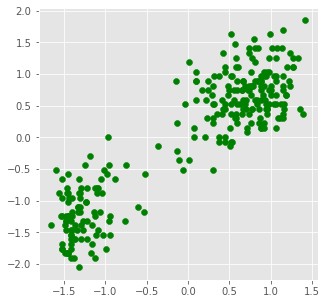

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import digamma
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use("ggplot")

data = pd.read_csv("/content/drive/My Drive/ColabNotebooks/PRML/9章/faithful.csv",sep=",")
print(data.head())
print(data.columns)
data.pop('Unnamed: 0')
print(data.head())
data = data.values
print(data.shape)
data_center = np.array([data[:,0].mean(),data[:,1].mean()])
print(data_center)
center_data = data - data_center
plt.figure(figsize=(5,5))
data = center_data / np.array([data[:,0].std(), data[:,1].std()])
plt.scatter(data[:,0], data[:,1], c="g")

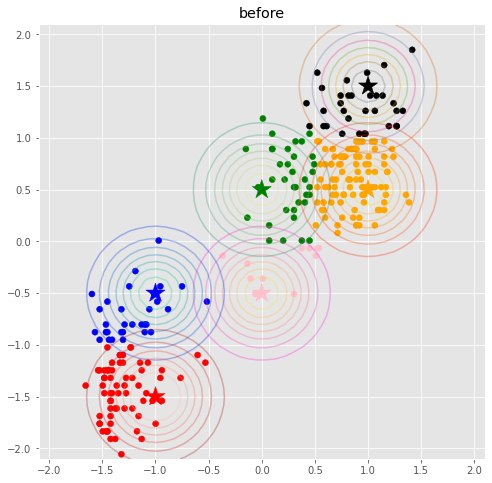

In [8]:
D = 2
K = 6
N = len(data)

mu = np.array([[0., -0.5],[0., 0.5], [1., 0.5], [-1., -0.5], [-1, -1.5], [1, 1.5]]) # (K, D)
S = np.array([0.1 * np.eye(D) for _ in range(K)]) # (K, D, D)

alpha_0 = 1e-3
beta_0 = 1e-3
m_0 = np.zeros((K, D))
nu_0 = 1
W_0 = np.eye(D)

W_k = np.zeros((K, D, D))
E_mu_lam = np.zeros((N, K))

def multi_gauss(x, y, mu, sigma):
  return stats.multivariate_normal(mu, sigma).pdf(np.array([x,y]))

r = np.ones((K,N,D))/K
pi = np.ones(K) / K
g = [ np.vectorize(lambda x,y: pi[k] * multi_gauss(x,y,mu[k],S[k]))(data[:,0], data[:,1]) for k in range(K)] # (K, N)
g = np.array(g)
r = g / (g.sum(axis=0))[np.newaxis,] # (K, N) / (1, N)
r = r.T
X, Y = np.meshgrid(np.linspace(-2.1, 2.1), np.linspace(-2.1, 2.1))

cmap_colors = [cm.spring, cm.summer, cm.autumn, cm.winter, cm.Reds_r, cm.Dark2]
colors = ["pink", "green", "orange", "blue", "red", "black"]
plt.figure(figsize=(8,8))
Z = [ np.vectorize(lambda x,y: multi_gauss(x, y, mu[k], S[k]))(X, Y) for k in range(K)]
Z = np.array(Z)
for k in range(K):
  plt.contour(X,Y,Z[k], cmap=cmap_colors[k], alpha=0.3)

plt.scatter(mu[:, 0], mu[:, 1], s=400, marker="*", c=colors)
plt.scatter(data[:,0] , data[:,1], c = list(map(lambda x: colors[x], r.argmax(axis=1))))
plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)
plt.title(u"before")
plt.show()

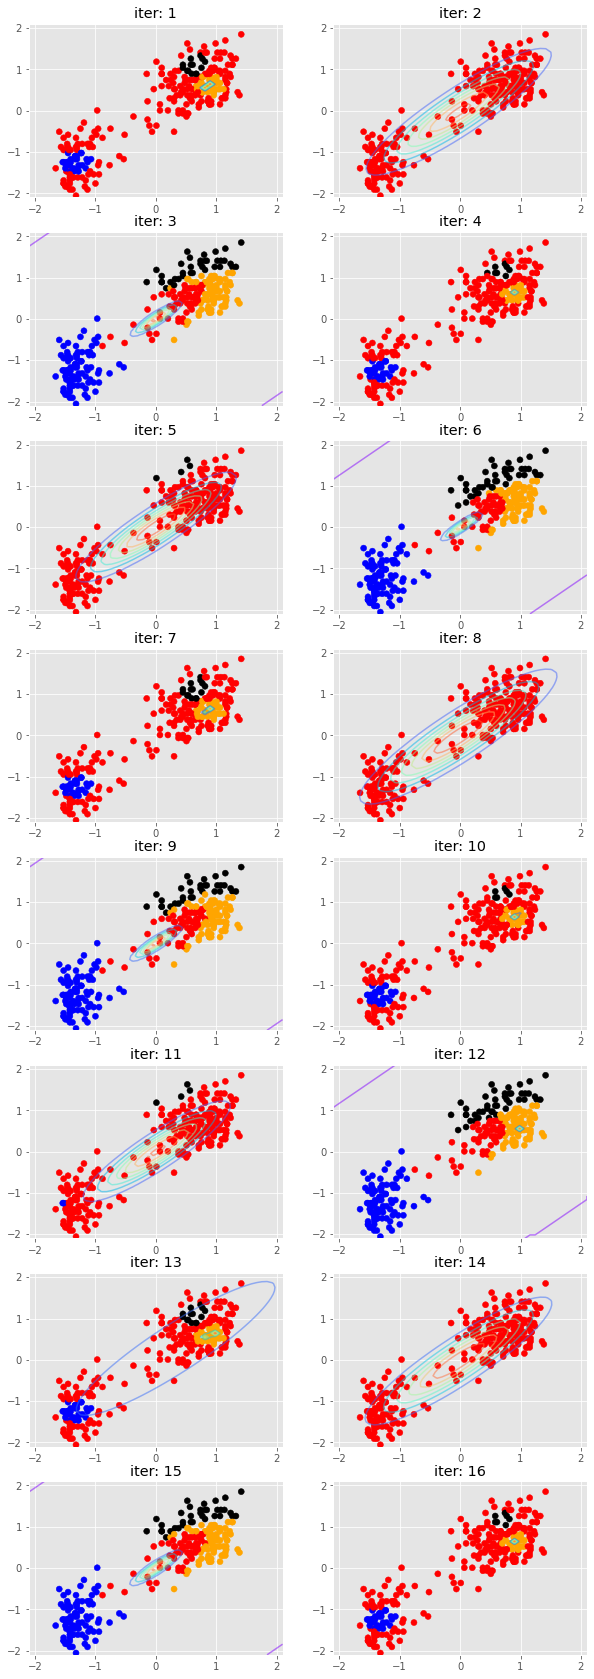

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [10]:
import numpy.linalg as LA
fig, axes = plt.subplots(8,2, figsize=(10,30))
axes = axes.flatten()
## r: size=(K,N)
## data: size=(N,D)
## mu: size=(K, D)
for i in range(16):
  N_k = r.sum(0) #(K)
  mu = r.T @ data / np.c_[N_k]#(K, D)
  S = np.array([ (r[k][-1,np.newaxis] *(data - mu[k][np.newaxis,])).T@((data - mu[k][np.newaxis,])) / N_k[k] for k in range(K)])
  # outer: size=(D,D)
  # r * outer: (D,D)
  # S: size=(K,D,D)
  
  # M step
  #3: Mstep
  alpha = alpha_0 + N_k
  beta = beta_0 + N_k
  m_k = (beta_0 * m_0 + np.c_[N_k] * mu) / np.c_[beta]
  for k in range(K):
    tmp1 = beta_0 * N_k[k] * np.outer(mu[k] - m_0[k], mu[k] - m_0[k]) / (beta_0 + N_k[k])
    tmp2 = LA.inv(W_0) + N_k[k] * S[k] + tmp1
    W_k[k] = LA.inv(tmp2)
    
  nu_k = nu_0 + N_k

  #4: Estep
  E_ln_lam = digamma(nu_k / 2) + digamma((nu_k - 1) / 2) + D * np.log(2) + np.log([LA.norm(w) for w in W_k])
  E_ln_pi = digamma(alpha) - digamma(alpha.sum())
  for k in range(K):
      E_mu_lam[:, k] = D / beta[k] + nu_k [k] * np.diag((data - m_k[k]).dot(W_k[k]).dot((data - m_k[k]).T))
  ro = np.exp(E_ln_pi + E_ln_lam / 2. - D * np.log(2 * np.pi) / 2. - E_mu_lam / 2.)
  r = ro / np.c_[ro.sum(1)]
  r[r < 1e-10] = 1e-10
 
  #図示
  plt.figure(figsize=(5, 5))
  X, Y = np.meshgrid(np.linspace(-2.1, 2.1), np.linspace(-2.1, 2.1))
  pi = np.exp(E_ln_pi)
  Z = np.vectorize(lambda x, y: np.sum([pi[k] * multi_gauss(x, y, mu[k], S[k]) for k in range(K)]))(X, Y)
  axes[i].contour(X, Y, Z, cmap=cm.rainbow, alpha=0.5)
  axes[i].scatter(data[:,0] , data[:,1], c = list(map(lambda x: colors[x], r.argmax(1))))
  axes[i].set_xlim(-2.1, 2.1)
  axes[i].set_ylim(-2.1, 2.1)
  axes[i].set_title("iter: {}".format(i+1))

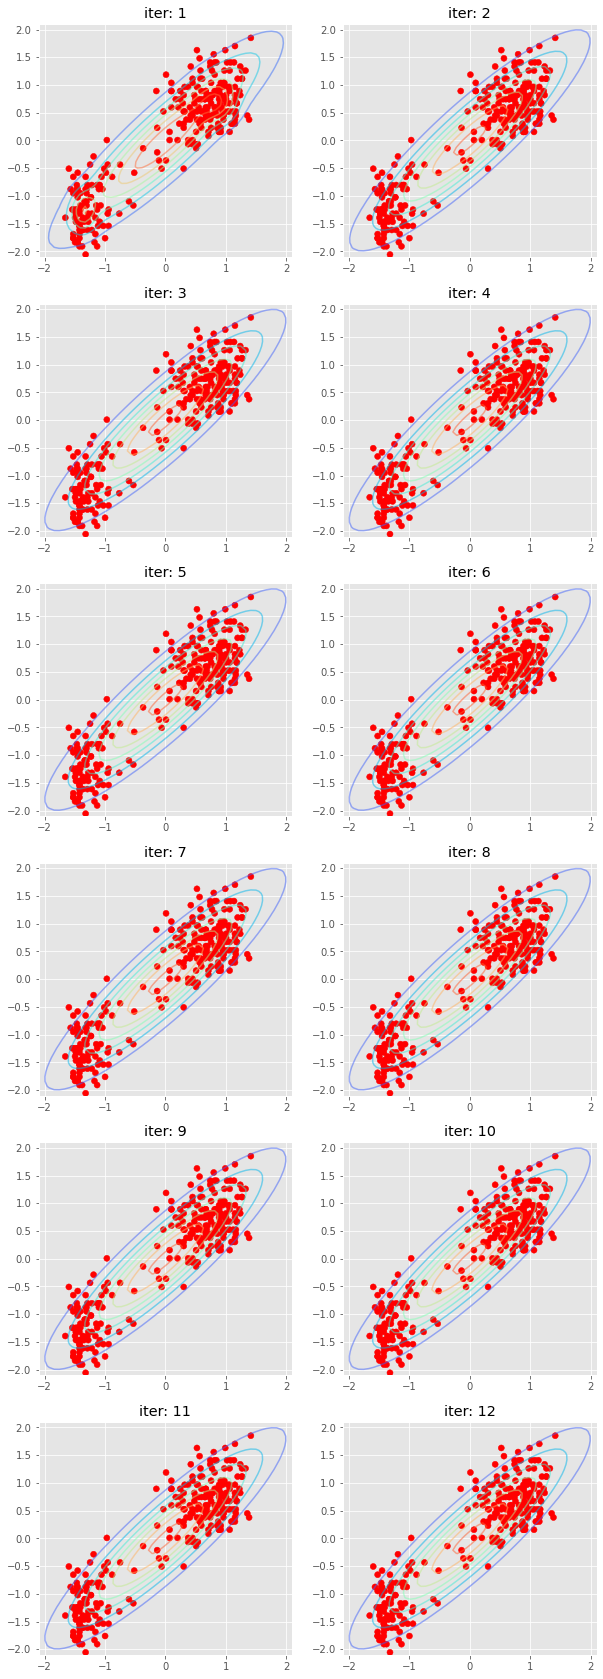

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [12]:
fig, axes = plt.subplots(6, 2, figsize=(10, 30))
axes = axes.flatten()
for i in range(12):
    #2: 三つの統計量を計算
    N_k = r.sum(0)
    mu = r.T.dot(data) / np.c_[N_k]
    for k in range(K):
        S[k] = (np.c_[r[:, k]] * (data - mu[k])).T.dot(data - mu[k]) / N_k[k]
 
    #3: Mstep
    alpha = alpha_0 + N_k
    beta = beta_0 + N_k
    m_k = (beta_0 * m_0 + np.c_[N_k] * mu) / np.c_[beta]
    for k in range(K):
        tmp1 = beta_0 * N_k[k] * np.outer(mu[k] - m_0[k], mu[k] - m_0[k]) / (beta_0 + N_k[k])
        tmp2 = LA.inv(W_0) + N_k[k] * S[k] + tmp1
        W_k[k] = LA.inv(tmp2)
    nu_k = nu_0 + N_k
 
    #4: Estep
    E_ln_lam = digamma(nu_k / 2) + digamma((nu_k - 1) / 2) + D * np.log(2) + np.log([LA.norm(w) for w in W_k])
    E_ln_pi = digamma(alpha) - digamma(alpha.sum())
    for k in range(K):
        E_mu_lam[:, k] = D / beta[k] + nu_k [k] * np.diag((data - m_k[k]).dot(W_k[k]).dot((data - m_k[k]).T))
    ro = np.exp(E_ln_pi + E_ln_lam / 2. - D * np.log(2 * np.pi) / 2. - E_mu_lam / 2.)
    r = ro / np.c_[ro.sum(1)]
    r[r < 1e-10] = 1e-10
 
    #図示
    plt.figure(figsize=(5, 5))
    X, Y = np.meshgrid(np.linspace(-2.1, 2.1), np.linspace(-2.1, 2.1))
    pi = np.exp(E_ln_pi)
    Z = np.vectorize(lambda x, y: np.sum([pi[k] * multi_gauss(x, y, mu[k], S[k]) for k in range(K)]))(X, Y)
    axes[i].contour(X, Y, Z, cmap=cm.rainbow, alpha=0.5)
    axes[i].scatter(data[:,0] , data[:,1], c = list(map(lambda x: colors[x], r.argmax(1))))
    axes[i].set_xlim(-2.1, 2.1)
    axes[i].set_ylim(-2.1, 2.1)
    axes[i].set_title("iter: {}".format(i+1))